# Анализ лояльности пользователей Яндекс Афиши.

- Автор: Карепанов Андрей
- Дата: 

### Цели и задачи проекта

Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно

## Описание данных.

* user_id — уникальный идентификатор пользователя, совершившего заказ;
* device_type_canonical — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
* order_id — уникальный идентификатор заказа;
* order_dt — дата создания заказа (используйте данные created_dt_msk );
* order_ts — дата и время создания заказа (используйте данные created_ts_msk );
* currency_code — валюта оплаты;
* revenue — выручка от заказа;
* tickets_count — количество купленных билетов;
* days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
* event_id — уникальный идентификатор мероприятия;
* service_name — название билетного оператора;
* event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);
* region_name — название региона, в котором прошло мероприятие;
* city_name — название города, в котором прошло мероприятие.

## Содержимое проекта 

* Загрузка данных и их предобработка
* Предобработка данных
* Создание профиля пользователя
* Исследовательский анализ данных
* Корреляционный анализ количества покупок и признаков пользователя
* Итоговый вывод и рекомендации.


## Загрузка данных и их предобработка.

In [1]:
# Установка библиотек 
pip install -r requirements.txt 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# импорт библиотек
import pandas as pd 
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных 
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеки для расчета коэффициента корреляции phi_k
from phik import phik_matrix

In [3]:
# данные для подключения к базе данных

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [2]:
# Форматирование строки подключения

connection_string = (
    f"postgresql+psycopg2://{db_config['user']}:{db_config['pwd']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)

# Создание подключения
engine = create_engine(connection_string)

NameError: name 'db_config' is not defined

In [5]:
# извлечение результатов SQL запроса
query = '''

WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  NULLIF(p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk), 0) AS days_since_prev,
  
  e.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  city.city_name,
  region.region_name

FROM afisha.purchases p
JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city city ON e.city_id = city.city_id
LEFT JOIN afisha.regions region ON city.region_id = region.region_id
WHERE p.device_type_canonical IN ('desktop', 'mobile')
  AND e.event_type_main != 'фильм' -- исключение заказов на фильмы
ORDER BY p.user_id
'''

df = pd.read_sql_query(query, con=engine)

ticket_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

print(df.head())

           user_id device_type_canonical  order_id   order_dt  \
0  0002849b70a3ce2                mobile   4359165 2024-08-20   
1  0005ca5e93f2cf4                mobile   7965605 2024-07-23   
2  0005ca5e93f2cf4                mobile   7292370 2024-10-06   
3  000898990054619                mobile   1139875 2024-07-13   
4  000898990054619                mobile    972400 2024-10-04   

             order_ts currency_code  revenue  tickets_count  days_since_prev  \
0 2024-08-20 16:08:03           rub  1521.94              4              NaN   
1 2024-07-23 18:36:24           rub   289.45              2              NaN   
2 2024-10-06 13:56:02           rub  1258.57              4             75.0   
3 2024-07-13 19:40:48           rub     8.49              2              NaN   
4 2024-10-04 22:33:15           rub  1390.41              3             83.0   

   event_id                            event_name event_type_main  \
0    169230  f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad          

In [6]:
# Выводим информацию о датафрейме 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        84626 non-null   float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [7]:
ticket_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [8]:
ticket_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


### Промежуточный вывод

Датасет df 15 столбцов и 290611 строк в которых предоставлена информация о покупателях билетов на общественные мероприятия

* Можно понизить размерность столбцов tickets_count, days_since_prev.
* столбец days_since_prev содержит пропуски. в данном столбце содержится количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено.
* столбец days_since_prev можно преобразовать из float в Int, так как в нем содержатся целые числа.

Датасет ticket_tenge содержит 357 строк и 4 столбца, информацию о курсе казахстанского тенге по отношению к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.

* можно понизить размерноость столбца nominal

требуется объеденить датасеты в один для последующего преобразования выручки из тенге в рубли

## Предобработка данных

In [9]:
# Приводим столбец data в датафрейме ticket_tenge в формат datetime

ticket_tenge['data'] = pd.to_datetime(ticket_tenge['data'])

In [10]:
# OбЪединяем данные по дате заказа 

df_convert = df.merge(
    ticket_tenge
    , left_on='order_dt'
    , right_on='data'
    , how='left'
)
df_convert.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        84626 non-null   float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [11]:
# Изменяем тип данных в столбце days_since_prev из float64 в Int

df_convert['days_since_prev'] = pd.to_numeric(df_convert['days_since_prev'], errors = 'coerce').astype('Int64')

In [12]:
# Снижаем размерность столбцов tickets_count, days_since_prev, nominal
df_convert['tickets_count'] = pd.to_numeric(df_convert['tickets_count'], downcast = 'integer')
df_convert['days_since_prev'] = pd.to_numeric(df_convert['days_since_prev'], downcast = 'integer')
df_convert['nominal'] = pd.to_numeric(df_convert['nominal'], downcast = 'integer')

df_convert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        84626 non-null   Int16         
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [13]:
# Считаем кол-во пропуска в столбцах и процент
result = (
    df_convert.isna().sum()
    .reset_index(name='Кол-во')
    .rename(columns={'index': 'Столбец'})
    .assign(Процент=lambda x: x['Кол-во'] / len(df) * 100)
    .sort_values(by='Процент', ascending=False)
    .reset_index(drop=True)
)

styled_result = result.style.format({'Процент': '{:.2f}%'})


styled_result

,Столбец,Кол-во,Процент
0,days_since_prev,205985,70.88%
1,device_type_canonical,0,0.00%
2,user_id,0,0.00%
3,order_id,0,0.00%
4,order_dt,0,0.00%
5,currency_code,0,0.00%
6,order_ts,0,0.00%
7,revenue,0,0.00%
8,tickets_count,0,0.00%
9,event_id,0,0.00%


In [14]:
# Изучаем уникальные значения столбца device_type_canonical в датафрейме df
df_convert['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [15]:
# Изучаем уникальные значения столбца currency_code в датафрейме df
df_convert['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [16]:
# Изучаем уникальные значения столбца event_type_main в датафрейме df
df_convert['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [17]:
# Изучаем уникальные значения столбца service_name в датафрейме df
df_convert['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

In [18]:
# Изучаем уникальные значения столбца city_name в датафрейме df
df_convert['city_name'].unique()

array(['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск',
       'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай',
       'Верховино', 'Светополье', 'Кокжар', 'Каменский', 'Лесоярич',
       'Никольянов', 'Речинцево', 'Лесозолотск', 'Дальнозерск',
       'Серебрянка', 'Островецк', 'Родниковец', 'Дальнесветск',
       'Луговаярово', 'Ягодиновка', 'Дальнополин', 'Солчелуг', 'Озёрчане',
       'Серебровино', 'Лесоярово', 'Глинополье', 'Глиноград',
       'Дальнесветин', 'Северополье', 'Теплоозеро', 'Горнодолинск',
       'Ордакент', 'Озёрово', 'Луговинск', 'Лугоград', 'Златопольск',
       'Крутовинск', 'Сарыжар', 'Сосновечин', 'Тихоярск', 'Яблонецк',
       'Жаркентай', 'Широковка', 'Синеводов', 'Синеводск', 'Тихосветск',
       'Радужанов', 'Каменосветск', 'Глиногорь', 'Родниковск',
       'Травогород', 'Глинянск', 'Радужинск', 'Поляногорье',
       'Дальнолесье', 'Ручейник', 'Ключеград', 'Ключеводск', 'Поленовино',
       'Речичанск', 'Ключевополье', 'Шаныртау', 'Дальнесоснов'

In [19]:
# Изучаем уникальные значения столбца region_name в датафрейме df
df_convert['region_name'].unique()

array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

In [20]:
df_convert['cdx'].unique()

array(['kzt'], dtype=object)

In [21]:
# Проведем нормализацию данных в столбцах типа object в датафрейме df

columns = ['device_type_canonical'
           , 'currency_code'
           , 'event_type_main'
           , 'service_name'
           , 'city_name'
           , 'region_name'
           , 'cdx'
          ]

# Приводим все столбцы к строкам
for col in columns:
    df_convert[col] = df_convert[col].astype(str)

# Приводим к нижнему регистру
for col in columns:
    df_convert[col] = df_convert[col].str.lower()

# Убираем точки в конце
for col in columns:
    df_convert[col] = df_convert[col].str.rstrip('.')

# Убираем пробелы в начале и конце
for col in columns:
    df_convert[col] = df_convert[col].str.strip()

#  Заменяем все знаки препинания и пробелы на "_"
pattern = r'[^\w]+'
for col in columns:
    df_convert[col] = df_convert[col].str.replace(pattern, '_', regex=True)
    # Заменим строки 'nan' обратно на None (или оставим как есть)
    df_convert[col] = df_convert[col].replace('nan', None)

df_convert.sample(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,nominal,curs,cdx
286653,fdc0dbdfe1c6938,mobile,6290536,2024-06-26,2024-06-26 11:08:55,rub,651.77,3,4,537207,f9e31a1b-1f80-4b54-b7e8-47be975ec1f1,концерты,облачко,лесоярич,озернинский_край,2024-06-26,100,18.7580,kzt
8476,043f669c9f734b1,mobile,594675,2024-10-18,2024-10-18 21:57:22,rub,787.03,2,<NA>,442181,d23aa983-cd4a-459f-9127-e04a14b08339,концерты,билеты_в_руки,лесоярич,озернинский_край,2024-10-18,100,19.8697,kzt
191386,9f0cddaba3378c8,mobile,6314722,2024-09-18,2024-09-18 22:14:08,rub,752.51,2,<NA>,188276,0714435e-3b5f-4312-aa36-c3a9d8853ef4,театр,весь_в_билетах,родниковецк,озернинский_край,2024-09-18,100,19.0236,kzt
53394,1fa43bbdca7959d,mobile,5558634,2024-08-22,2024-08-22 08:25:31,rub,45.60,2,<NA>,462145,99090d4a-1553-49bd-83a9-de64cc70f80f,театр,билеты_в_руки,глинополье,солнечноземская_область,2024-08-22,100,19.2291,kzt
187980,9b819531bd465b4,mobile,5296474,2024-08-27,2024-08-27 10:21:06,rub,282.72,1,1,546440,1ae1f504-0595-4534-a339-ceb65e162401,концерты,мир_касс,ягодиновка,широковская_область,2024-08-27,100,19.0096,kzt


In [22]:
# Поиск дубликатов
duplicates_count = df_convert.duplicated(subset = 'order_id').sum()
print(duplicates_count)
# Посчитаем долю дубликатов
duplicates_share = df_convert.duplicated(subset = 'order_id').sum() / len(df_convert)
print(duplicates_share)

0
0.0


дубликаты не найдены

In [23]:
# Создаем функцию для конвертации тенге в рубли

def convert_revenue(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        kurs = row['curs'] / 100
        return row['revenue'] * kurs

# Применяем функцию 
df_convert['revenue_rub'] = df_convert.apply(convert_revenue, axis=1)

df_convert.head()


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,<NA>,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край_билетов,глиногорск,каменевский_регион,2024-08-20,100,18.6972,kzt,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,<NA>,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой_билет,глиногорск,каменевский_регион,2024-07-23,100,18.3419,kzt,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за_билетом_,глиногорск,каменевский_регион,2024-10-06,100,19.6475,kzt,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,<NA>,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови_билет_,озёрск,североярская_область,2024-07-13,100,18.5010,kzt,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты_без_проблем,родниковецк,озернинский_край,2024-10-04,100,19.6648,kzt,1390.41


       tickets_count    revenue_rub
count  290611.000000  290611.000000
mean        2.754311     555.571987
std         1.170620     875.498172
min         1.000000     -90.760000
25%         2.000000     113.970000
50%         3.000000     351.140000
75%         4.000000     802.050000
max        57.000000   81174.540000


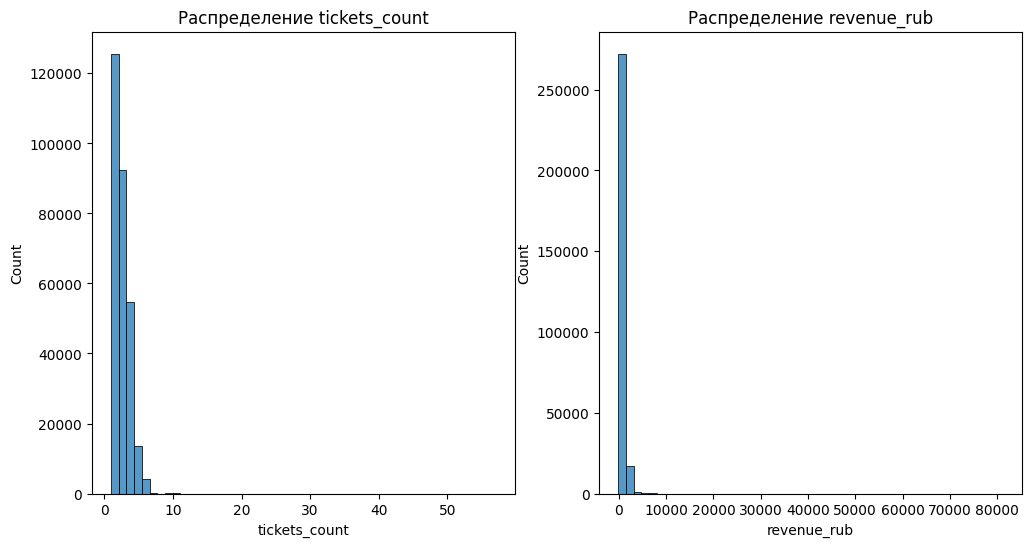

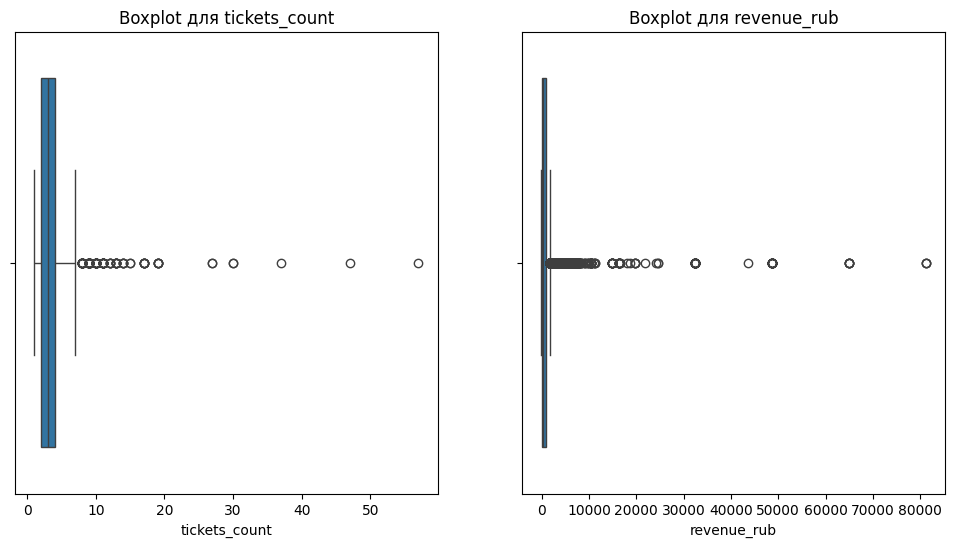

In [24]:
# Статистика по 'tickets_count' и 'revenue_rub'
print(df_convert[['tickets_count', 'revenue_rub']].describe())

# Гистограмма распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_convert['tickets_count'], bins=50)
plt.title('Распределение tickets_count')

plt.subplot(1, 2, 2)
sns.histplot(df_convert['revenue_rub'], bins=50)
plt.title('Распределение revenue_rub')

plt.show()

# Диаграммы размаха 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_convert['tickets_count'])
plt.title('Boxplot для tickets_count')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_convert['revenue_rub'])
plt.title('Boxplot для revenue_rub')

plt.show()

в столбцах tickets_count и revenue_rub имеются серьезные выбросы. Целесообразно отфильтровать их по 99 перцентилю.

In [25]:
# Расчет 99-го перцентиля для столбца revenue_rub
percentile_99_revenue_rub = df_convert['revenue_rub'].quantile(0.99)

# Расчет 99-го перцентиля для столбца tickets_count
percentile_99_tickets_count = df_convert['tickets_count'].quantile(0.99)

# Фильтрация данных
df_filtered = df_convert[
    (df_convert['revenue_rub'] <= percentile_99_revenue_rub) &
    (df_convert['tickets_count'] <= percentile_99_tickets_count)
]

print("Общее количество строк ДО фильтрации:", len(df_convert))
print("Общее количество строк ПОСЛЕ фильтрации:", len(df_filtered))
print("Исключено строк:", len(df_convert) - len(df_filtered))
print()
df_filtered.info()

Общее количество строк ДО фильтрации: 290611
Общее количество строк ПОСЛЕ фильтрации: 287606
Исключено строк: 3005

<class 'pandas.core.frame.DataFrame'>
Index: 287606 entries, 0 to 290610
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287606 non-null  object        
 1   device_type_canonical  287606 non-null  object        
 2   order_id               287606 non-null  int64         
 3   order_dt               287606 non-null  datetime64[ns]
 4   order_ts               287606 non-null  datetime64[ns]
 5   currency_code          287606 non-null  object        
 6   revenue                287606 non-null  float64       
 7   tickets_count          287606 non-null  int8          
 8   days_since_prev        83792 non-null   Int16         
 9   event_id               287606 non-null  int64         
 10  event_name             287606 non-null  object       

       tickets_count    revenue_rub
count  287606.000000  287606.000000
mean        2.735638     517.791295
std         1.136194     511.874111
min         1.000000     -90.760000
25%         2.000000     111.690000
50%         3.000000     343.700000
75%         3.000000     788.630000
max         6.000000    2628.421739


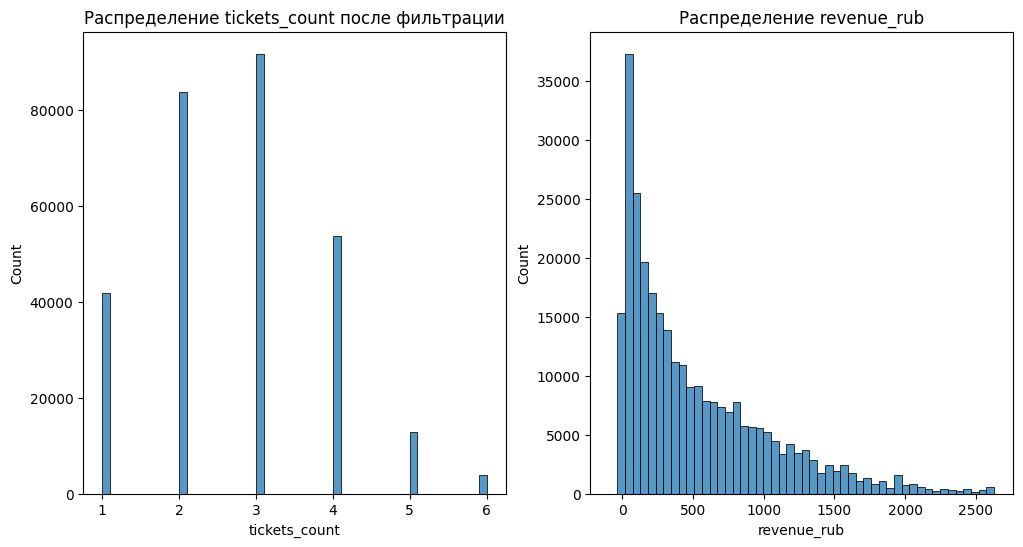

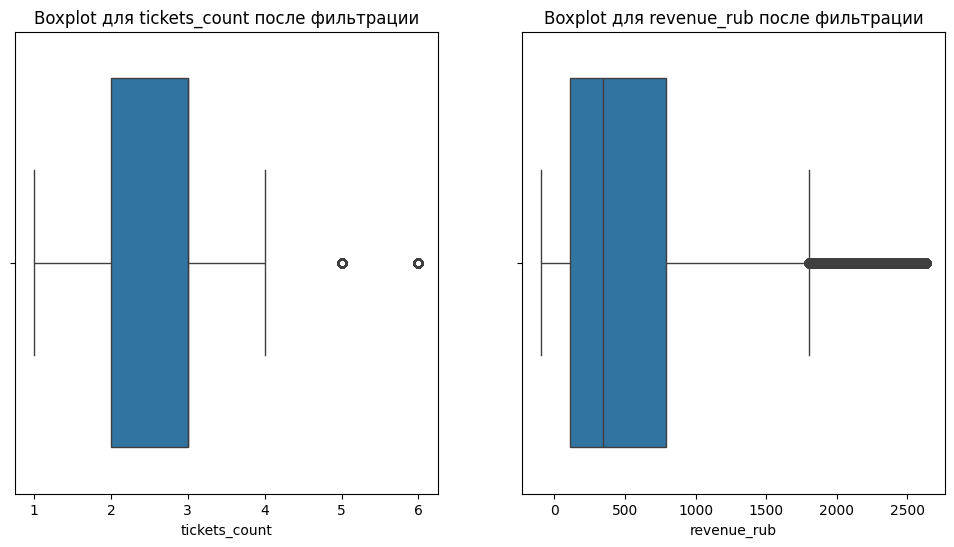

In [26]:
# Статистика по 'tickets_count' и 'revenue_rub' после фильтрации
print(df_filtered[['tickets_count', 'revenue_rub']].describe())

# Гистограмма распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['tickets_count'], bins=50)
plt.title('Распределение tickets_count после фильтрации')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['revenue_rub'], bins=50)
plt.title('Распределение revenue_rub')

plt.show()

# Диаграммы размаха 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_filtered['tickets_count'])
plt.title('Boxplot для tickets_count после фильтрации')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['revenue_rub'])
plt.title('Boxplot для revenue_rub после фильтрации')

plt.show()

### Промежуточный вывод

Было проведено:

* Приведение столбца data в датафрейме ticket_tenge в формат datetime.
* OбЪединение данных датафреймов df и ticket_tenge по дате заказа.
* Изменение типа данных в столбце days_since_prev из float64 в Int.
* Снижена размерность столбцов tickets_count, days_since_prev, nominal.
* Найдено 205985 пропусков в столбце days_since_prev, что составляет 70.88%.
* Нормализация данных в столбцах:
  'device_type_canonical'
  , 'currency_code'
  , 'event_type_main'
  , 'service_name'
  , 'city_name'
  , 'region_name'
  , 'cdx'.
* Дубликаты не найдены
* Выручка конвертирована из тенге в рубли, добавлено в столбец revenue_rub
* Определена статистика по столбцам 'tickets_count', 'revenue_rub'.
* Найдены выбросы в данных столбцов 'tickets_count', 'revenue_rub'.
* Датафрейм отфильтрован по 99 перцентилю  в столбцах 'tickets_count', 'revenue_rub'.
* Общее количество строк ДО фильтрации: 290611,
* Общее количество строк ПОСЛЕ фильтрации: 287606,
* Исключено строк: 3005.
  

## Создание профиля пользователя

In [27]:
# Сортируем по времени заказа
df_sorted = df_filtered.sort_values(by='order_ts')

# Создаем лаговую переменную для времени предыдущего заказа
df_sorted['prev_order_dt'] = df_sorted.groupby('user_id')['order_dt'].shift(1)

# Рассчитываем разницу в днях между заказами
df_sorted['diff_days'] = (df_sorted['order_dt'] - df_sorted['prev_order_dt']).dt.total_seconds() / (3600 * 24)

# Создаем агрегировать по пользователю
profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min')
    , last_order_dt=('order_dt', 'max')
    , first_device_type_canonical=('device_type_canonical', 'first')
    , first_region_name=('region_name', 'first')
    , first_service_name=('service_name', 'first')
    , first_event_type_main=('event_type_main', 'first')
    , total_orders=('order_id', 'count')
    , mean_revenue_rub=('revenue_rub', 'mean')
    , mean_tickets_count=('tickets_count', 'mean')
).reset_index()

# Среднее время между заказами
mean_diff = df_sorted.groupby('user_id')['diff_days'].mean().reset_index().rename(columns={'diff_days':'mean_days_between_orders'})

# Объединяем
profile = profile.merge(mean_diff, on='user_id', how='left')

# Создаем бинарные признаки
profile['is_two'] = (profile['total_orders'] >= 2).astype(int)
profile['is_five'] = (profile['total_orders'] >= 5).astype(int)

profile.head()
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21847 entries, 0 to 21846
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      21847 non-null  object        
 1   first_order_dt               21847 non-null  datetime64[ns]
 2   last_order_dt                21847 non-null  datetime64[ns]
 3   first_device_type_canonical  21847 non-null  object        
 4   first_region_name            21847 non-null  object        
 5   first_service_name           21847 non-null  object        
 6   first_event_type_main        21847 non-null  object        
 7   total_orders                 21847 non-null  int64         
 8   mean_revenue_rub             21847 non-null  float64       
 9   mean_tickets_count           21847 non-null  float64       
 10  mean_days_between_orders     13480 non-null  float64       
 11  is_two                       21847 non-nu

In [28]:
# считаем метрики
total_users = profile['user_id'].nunique()
avg_revenue_per_order = profile['mean_revenue_rub'].mean()
share_users_2_plus = (profile['is_two'].sum() / total_users)
share_users_5_plus = (profile['is_five'].sum() / total_users)
total_orders = profile['total_orders'].sum()
avg_tickets_in_order = profile['mean_tickets_count'].mean()
avg_days_between_orders = profile['mean_days_between_orders'].mean()

# Формируем словарь с метриками
metrics_dict = {
    'Показатель': [
        'Общее число пользователей'
        , 'Средняя выручка с одного заказа'
        , 'Доля пользователей, совершивших 2 и более заказа'
        , 'Доля пользователей, совершивших 5 и более заказов'
        , 'Общее число заказов'
        , 'Среднее число билетов в заказе'
        , 'Среднее число дней между покупками'
    ]
    , 'Значение': [
        total_users
        , avg_revenue_per_order
        , f"{share_users_2_plus:.2%}"
        , f"{share_users_5_plus:.2%}"
        , total_orders
        , f"{avg_tickets_in_order:.2f}"
        , f"{avg_days_between_orders:.2f}"
    ]
}

# Создаем DataFrame
summary_df = pd.DataFrame(metrics_dict)

# Выводим таблицу
print(summary_df)

                                          Показатель    Значение
0                          Общее число пользователей       21847
1                    Средняя выручка с одного заказа  544.161067
2   Доля пользователей, совершивших 2 и более заказа      61.70%
3  Доля пользователей, совершивших 5 и более заказов      29.01%
4                                Общее число заказов      287606
5                     Среднее число билетов в заказе        2.74
6                 Среднее число дней между покупками       15.87


In [29]:
# Создаем словарь с описательными статистиками для каждой колонки
stats_dict = {
    'total_orders': profile['total_orders'].describe(percentiles=[.25, .5, .75, .95, .99]),
    'mean_tickets_count': profile['mean_tickets_count'].describe(percentiles=[.25, .5, .75, .95, .99]),
    'mean_days_between_orders': profile['mean_days_between_orders'].dropna().describe(percentiles=[.25, .5, .75, .95, .99])
}

# Преобразуем словарь в DataFrame
stats_df = pd.DataFrame(stats_dict)

# Транспонируем, чтобы получились метки строк, а колонки — показатели
stats_df = stats_df.T

# Переименуем колонки для удобства
stats_df.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', '95%', '99%', 'max']

stats_df

,count,mean,std,min,25%,50%,75%,95%,99%,max
total_orders,21847.0,13.164553,121.581813,1.0,1.0,2.000000,5.000000,31.0,151.54,10168.0
mean_tickets_count,21847.0,2.739164,0.902689,1.0,2.0,2.750000,3.071429,4.0,5.00,6.0
mean_days_between_orders,13480.0,15.874575,22.261115,0.0,1.0,8.071429,20.500000,61.5,112.00,148.0


* Данных достаточно для анализа (более 21 тысячи пользователей).
* В данных есть выраженный «хвост» по количеству заказов, что нужно учитывать. Полезно ограничиться 99-м перцентилем для анализа total_orders.
* Данные по количеству билетов выглядят без выраженных аномалий.

In [30]:
# Фильтрация
# Расчет перцентилей
p99_total_orders = profile['total_orders'].quantile(0.99)  
p99_days_between_orders = profile['mean_days_between_orders'].quantile(0.99) 

# Применение фильтрации
filtered_profile = profile[
    (
        (profile['total_orders'] <= p99_total_orders) | profile['total_orders'].isna()
    ) &
    (
        (profile['mean_days_between_orders'] <= p99_days_between_orders) | profile['mean_days_between_orders'].isna()
    )
].copy()

# Проверка размеров
print(f"Общее количество записей до фильтрации: {profile.shape[0]}")
print(f"Общее количество после фильтрации: {filtered_profile.shape[0]}")
print()

# Вывод статистики по отфильтрованным данным
print(filtered_profile[['total_orders'
                        , 'mean_tickets_count'
                        , 'mean_days_between_orders'
                       ]].describe(percentiles=[.25, .5, .75, .95, .99]))

Общее количество записей до фильтрации: 21847
Общее количество после фильтрации: 21496

       total_orders  mean_tickets_count  mean_days_between_orders
count  21496.000000        21496.000000              13129.000000
mean       6.507490            2.739208                 15.015692
std       14.257726            0.907298                 19.478634
min        1.000000            1.000000                  0.000000
25%        1.000000            2.000000                  1.295652
50%        2.000000            2.750000                  8.250000
75%        5.000000            3.090909                 20.250000
95%       26.000000            4.000000                 56.300000
99%       79.000000            5.000000                 94.000000
max      151.000000            6.000000                112.000000


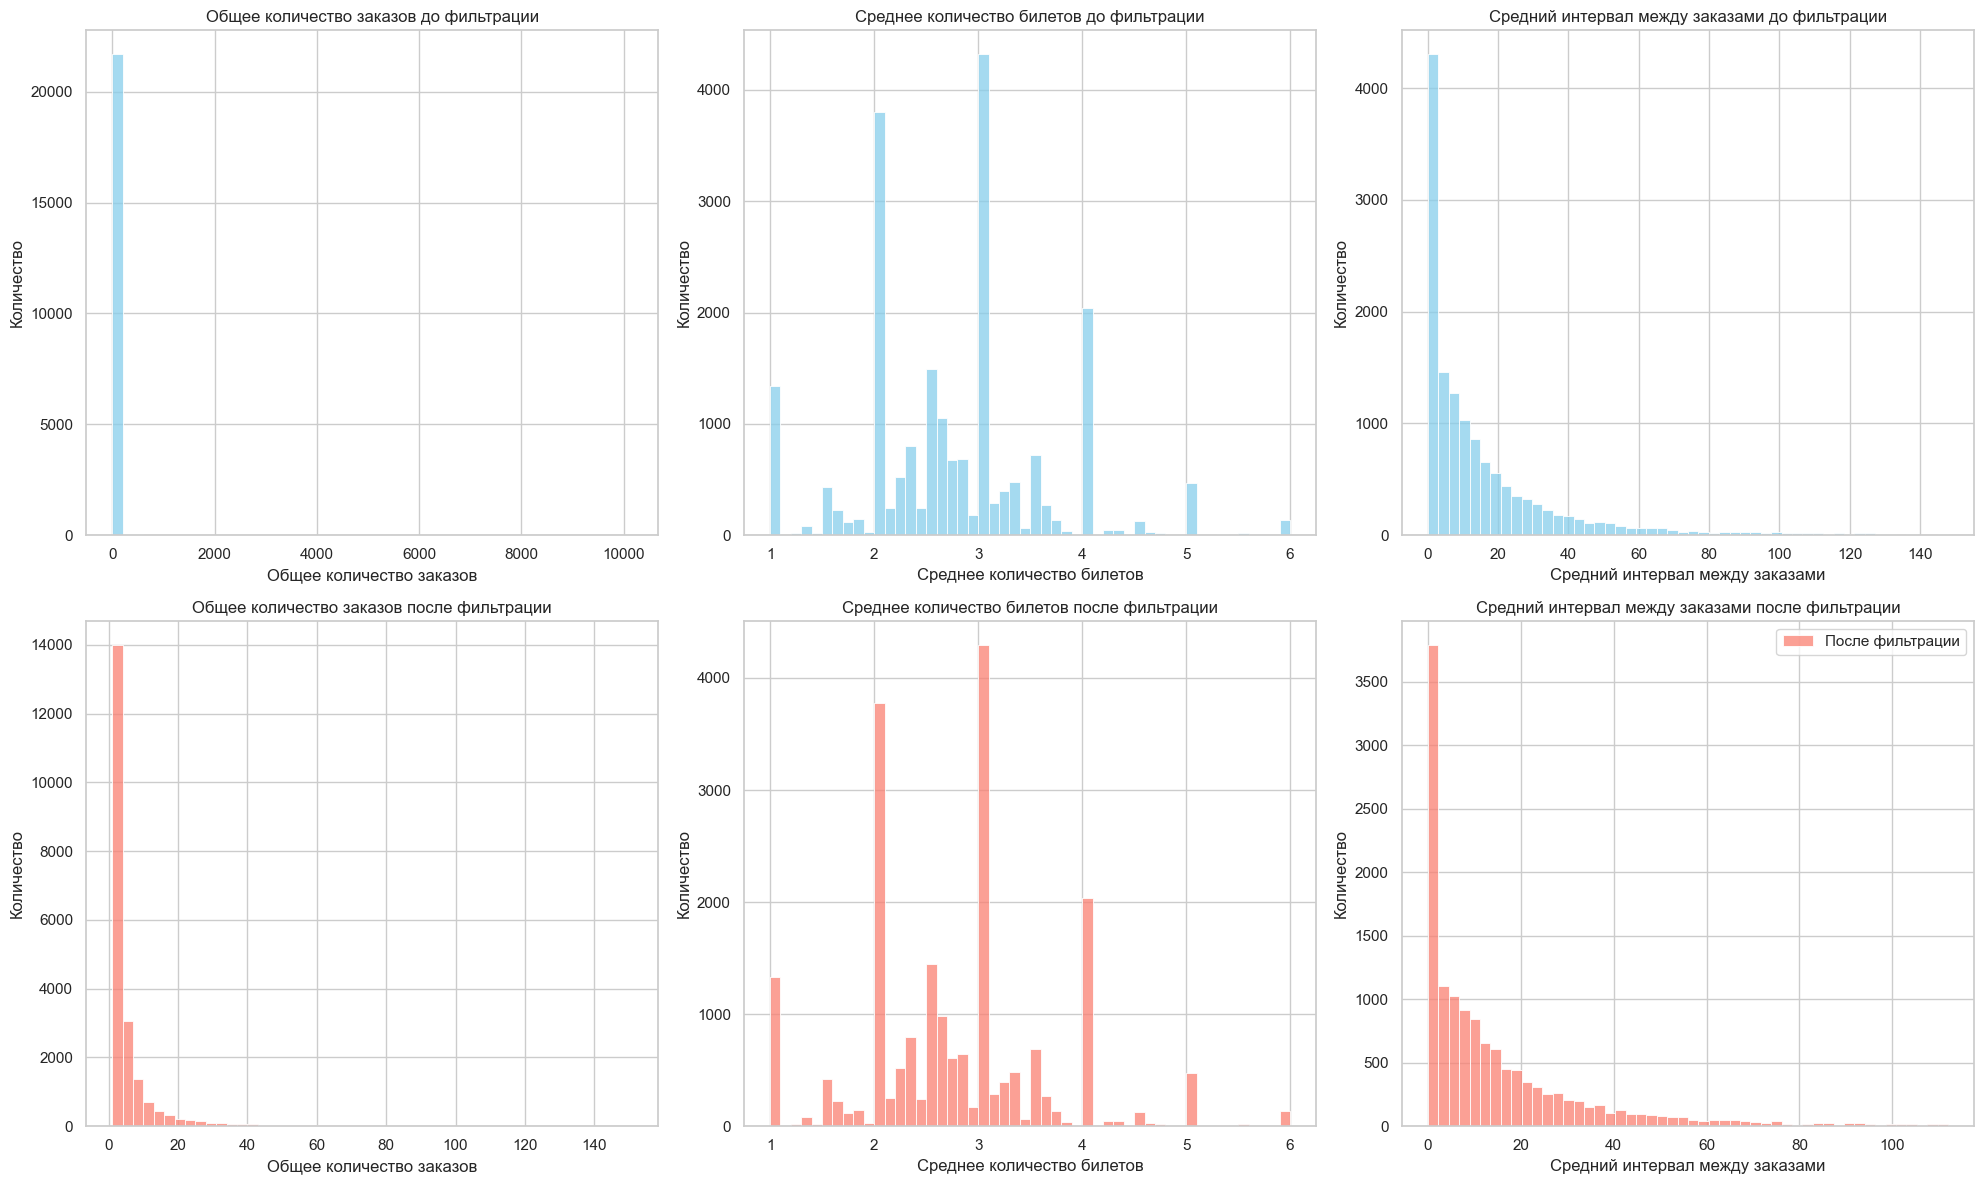

In [31]:
# строим графики для наглядности 
sns.set(style='whitegrid')
sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = [
    ('total_orders', 'Общее количество заказов'),
    ('mean_tickets_count', 'Среднее количество билетов'),
    ('mean_days_between_orders', 'Средний интервал между заказами')
]

for i, (col, title) in enumerate(metrics):
    # Гистограмма — до фильтрации
    sns.histplot(profile[col], bins=50, kde=False, color='skyblue', ax=axes[0, i], label='До фильтрации')
    axes[0, i].set_title(f'{title} до фильтрации')
    axes[0, i].set_xlabel(title)
    axes[0, i].set_ylabel('Количество')
    # Для разброса с большими значениями используем логарифмическую шкалу
    #if col == 'total_orders':
    #    axes[0, i].set_yscale('log')
    #    axes[0, i].set_ylabel('Логарифм количества')

    # Гистограмма — после фильтрации
    sns.histplot(filtered_profile[col], bins=50, kde=False, color='salmon', ax=axes[1, i], label='После фильтрации')
    axes[1, i].set_title(f'{title} после фильтрации')
    axes[1, i].set_xlabel(title)
    axes[1, i].set_ylabel('Количество')
    #if col == 'total_orders':
    #    axes[1, i].set_yscale('log')
    #    axes[1, i].set_ylabel('Логарифм количества')


plt.tight_layout()
plt.legend()
plt.show()

## Исследовательский анализ данных 

In [32]:
# Общее количество уникальных пользователей
total_users = filtered_profile['user_id'].nunique()

# тип первого мероприятия
segment_event_type = filtered_profile.groupby('first_event_type_main')['user_id'].nunique().reset_index()
segment_event_type['percentage'] = 100 * segment_event_type['user_id'] / total_users

# Устройство первого заказа
segment_device = filtered_profile.groupby('first_device_type_canonical')['user_id'].nunique().reset_index()
segment_device['percentage'] = 100 * segment_device['user_id'] / total_users

# Регион первого заказа
segment_region = filtered_profile.groupby('first_region_name')['user_id'].nunique().reset_index()
segment_region['percentage'] = 100 * segment_region['user_id'] / total_users

# Оператор билета первошо заказа
segment_service = filtered_profile.groupby('first_service_name')['user_id'].nunique().reset_index()
segment_service['percentage'] = 100 * segment_service['user_id'] / total_users


print(segment_event_type.sort_values('percentage', ascending=False))
print()
print(segment_device.sort_values('percentage', ascending=False))
print()
print(segment_region.sort_values('percentage', ascending=False))
print()
print(segment_service.sort_values('percentage', ascending=False))

  first_event_type_main  user_id  percentage
2              концерты     9493   44.161705
1                другое     5390   25.074432
5                 театр     4209   19.580387
4               стендап     1106    5.145143
3                 спорт      794    3.693710
0              выставки      409    1.902680
6                  ёлки       95    0.441943

  first_device_type_canonical  user_id  percentage
1                      mobile    17820   82.899144
0                     desktop     3676   17.100856

           first_region_name  user_id  percentage
23        каменевский_регион     7029   32.699107
60      североярская_область     3734   17.370674
77       широковская_область     1219    5.670822
45          озернинский_край      673    3.130815
41      малиновоярский_округ      522    2.428359
..                       ...      ...         ...
17            залесский_край        2    0.009304
70       тихогорская_область        2    0.009304
5          верхозёрский_край       

#### Промежуточный вывод

При сетментировании пользователей:
* По типу мероприятия первого заказа лидер концерты 44.1%, а второй тип, другое, 25.1%
* По типу устройства первого заказа лидер мобильный телефон 82.9%, а второй, компьютер 17.1%
* По региону первого заказа лидер каменевский_регион 32.7%, а второй, североярская_область 17.4%
* По опратору билетов первого заказа лидер билеты_без_проблем 23.9%, а второй, мой_билет 13.7%

In [33]:
# Перебираем каждый сегмент и выводим топ-10 результатов отдельно
for column in ['first_event_type_main', 'first_device_type_canonical', 'first_region_name', 'first_service_name']:
    # Расчет
    stats = profile.groupby(column).agg(
        total_users=('user_id', 'nunique'),
        users_with_2_plus_orders=('total_orders', lambda x: (x >= 2).sum())
    ).reset_index()

    # Процент
    stats['share_2_plus_percent'] = (stats['users_with_2_plus_orders'] / stats['total_users']) * 100

    # Сортируем по количеству пользователей и берем топ-10
    top_stats = stats.sort_values('total_users', ascending=False).head(10)

    # Выводим результаты
    print(f"\nТоп-10 по сегменту: {column}\n")
    print(top_stats.to_string(index=False))


Топ-10 по сегменту: first_event_type_main

first_event_type_main  total_users  users_with_2_plus_orders  share_2_plus_percent
             концерты         9643                      5994             62.159079
               другое         5482                      3292             60.051076
                театр         4290                      2738             63.822844
              стендап         1118                       684             61.180680
                спорт          801                       450             56.179775
             выставки          418                       269             64.354067
                 ёлки           95                        53             55.789474

Топ-10 по сегменту: first_device_type_canonical

first_device_type_canonical  total_users  users_with_2_plus_orders  share_2_plus_percent
                     mobile        18105                     11080             61.198564
                    desktop         3742                      24

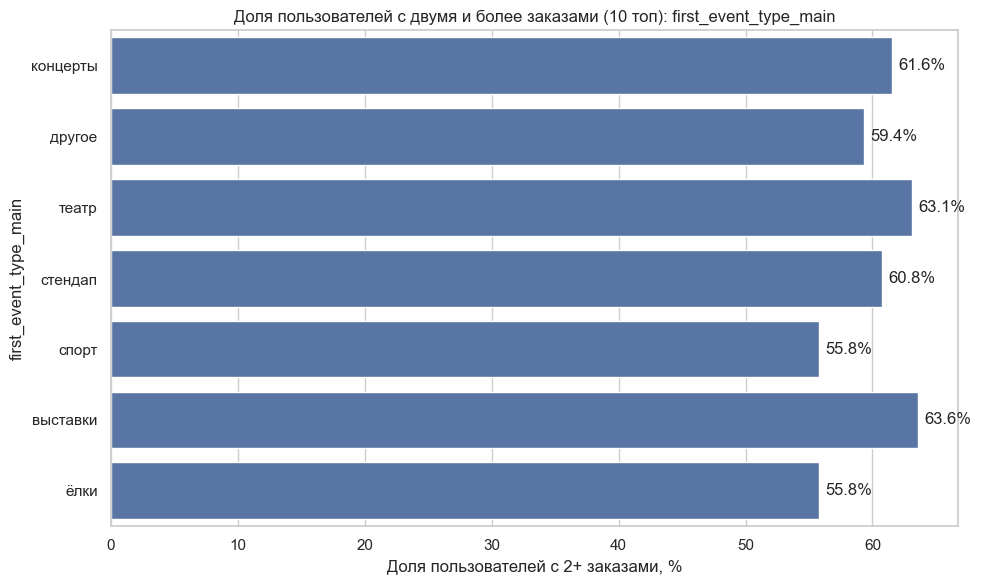

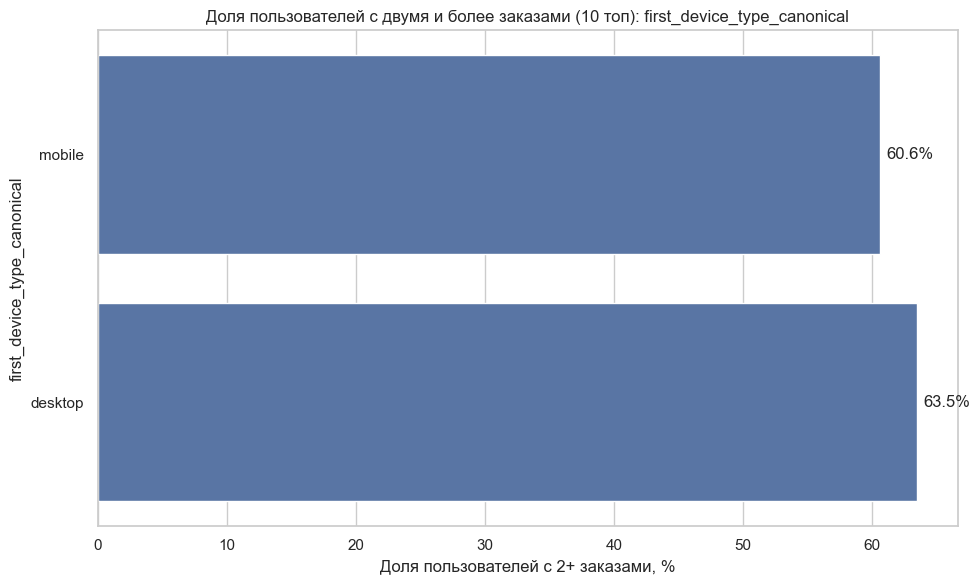

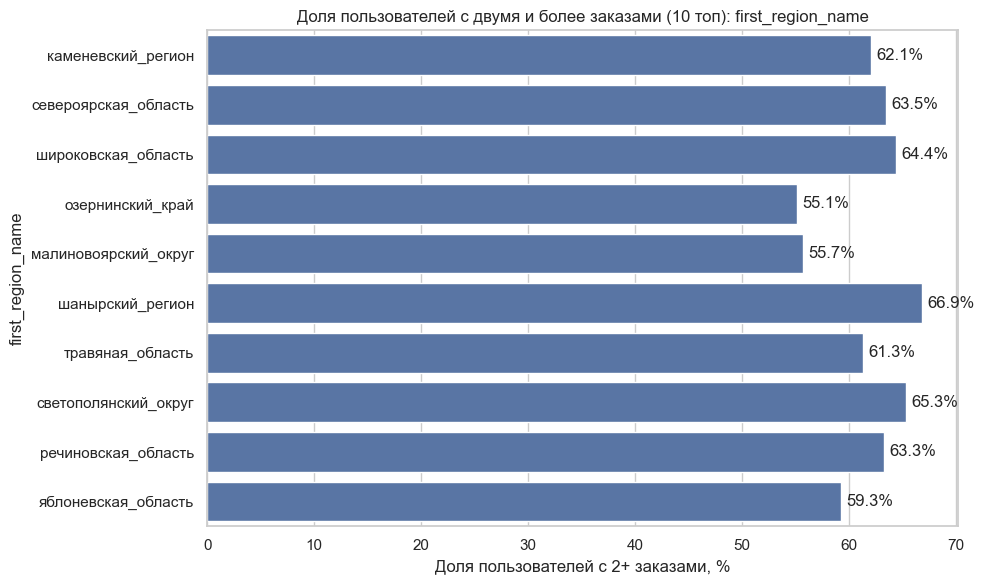

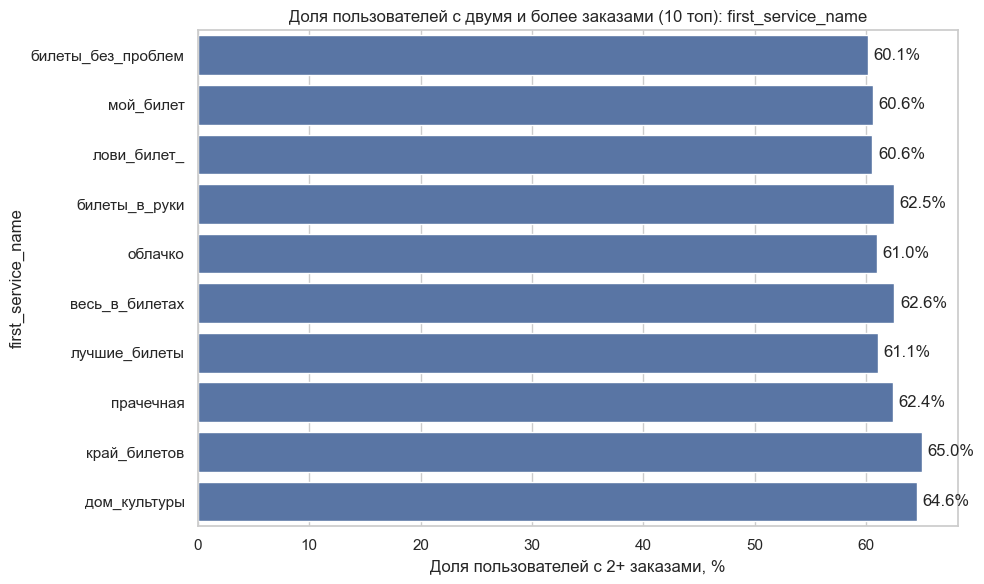

In [34]:

def plot_top_segments(segment_column, top_n=10):
    # Расчет по сегменту
    stats = filtered_profile.groupby(segment_column).agg(
        total_users=('user_id', 'nunique')
        , users_with_2_plus_orders=('total_orders', lambda x: (x >= 2).sum())
    ).reset_index()

    # Доля в процентах
    stats['share_2_plus_percent'] = (stats['users_with_2_plus_orders'] / stats['total_users']) * 100
    
    # Топ-N сегментов по количеству пользователей
    top_stats = stats.sort_values('total_users', ascending=False).head(top_n)
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_stats
        , x='share_2_plus_percent'
        , y=segment_column
    )

    plt.xlabel('Доля пользователей с 2+ заказами, %')
    plt.ylabel(segment_column)
    plt.title(f'Доля пользователей с двумя и более заказами ({top_n} топ): {segment_column}')
    plt.yticks(rotation=0)

    # Добавляем значения прямо на график
    for index, value in enumerate(top_stats['share_2_plus_percent']):
        plt.text(
            value + 0.5
            , index
            , f"{value:.1f}%"
            , va='center'
        )

    plt.tight_layout()
    plt.show()

# Вызов функции для нужных сегментов:
for column in ['first_event_type_main', 'first_device_type_canonical', 'first_region_name', 'first_service_name']:
    plot_top_segments(column)


#### Промежуточный вывод 

Наиболее активные и возвращающиеся пользователи по повторным заказам:

* По типу мероприятия (first_event_type_main):
    * "выставки" — 64.35%
    * "театр" — 63.82%
    * "концерты" — 62.16%

* По устройству (first_device_type_canonical):
    * "desktop" — 64.14%
    * "mobile" — 61.20%

* По регионам (first_region_name):
    * "шанышский регио" — 67.40%
    * "североярская область" — 64.07%
    * "широковская область" — 64.94%

* По типу сервиса (first_service_name):
    * "край билетов" — 65.58%
    * "весь в билетах" — 63.42%
    * "прачечная" — 62.93%


    «Точки входа» с высоким уровнем повторных заказов: регионы и сервисы с показателями выше 64-65%, такие как "шанышский регио", "край билетов".

C:\Users\pook\AppData\Local\Temp\ipykernel_10268\1474826596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contingency['returned'] = contingency['returned'].astype(int)


interval columns not set, guessing: ['returned']
                       first_event_type_main  returned
first_event_type_main               1.000000  0.028889
returned                            0.028889  1.000000


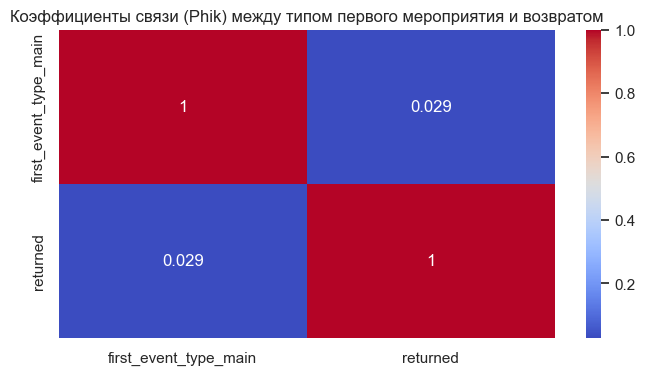

In [35]:
# Проверка гипотезы. Тип мероприятия влияет на вероятность возврата.

# Создаем новую категориальную переменную для возврата
filtered_profile['returned'] = filtered_profile['total_orders'] > 1 

# Анализ зависимости между 'first_event_type_main' и 'returned'
contingency = filtered_profile[['first_event_type_main', 'returned']]
contingency['returned'] = contingency['returned'].astype(int)

# Создаем матрицу
report = contingency.phik_matrix()
# Отобразим матрицу
print(report)

# Строим тепловую карту коэффициентов связи
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(report, annot=True, cmap='coolwarm')
plt.title('Коэффициенты связи (Phik) между типом первого мероприятия и возвратом')
plt.show()

коэффициент связи между типом первого мероприятия и возвратом всего 0.03, что означает очень слабую, практически отсутствующую, связь.

interval columns not set, guessing: ['returned']


C:\Users\pook\AppData\Local\Temp\ipykernel_10268\3484366211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contingency_region['returned'] = contingency_region['returned'].astype(int)


                   first_region_name  returned
first_region_name           1.000000  0.078032
returned                    0.078032  1.000000


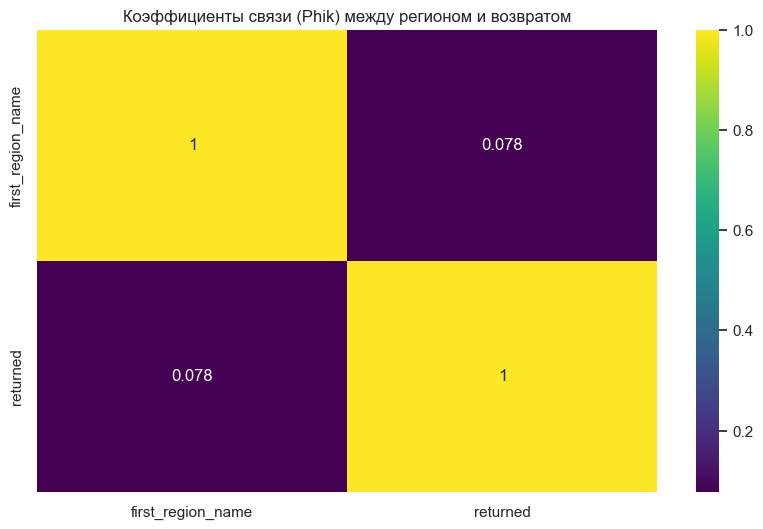

In [36]:
# Проверка гипотезы. Влияние региона на возврат.

#Анализ зависимости между регионом и возвратом
contingency_region = filtered_profile[['first_region_name', 'returned']]
contingency_region['returned'] = contingency_region['returned'].astype(int)

# Создаем матрицу связи
matrix_region = contingency_region.phik_matrix()
print(matrix_region)
# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(matrix_region, annot=True, cmap='viridis')
plt.title('Коэффициенты связи (Phik) между регионом и возвратом')
plt.show()


коэффициент связи между регионом первого заказа и возвратом составляет 0.08 что указывает на крайне слабую связь.


### Исследование поведения пользователей через показатели выручки и состава заказа

In [37]:
# Изучаем количественные характеристики заказов пользователей
# Средняя выручка на пользователя
average_revenue_per_user = filtered_profile['mean_revenue_rub'].mean()

# Среднее количество заказов на пользователя
average_orders_per_user = filtered_profile['total_orders'].mean()

# Оценка средней выручки с одного заказа (на основе среднего дохода на пользователя и среднего числа заказов)
average_revenue_per_order = average_revenue_per_user / average_orders_per_user

print(f"Средняя выручка на пользователя: {average_revenue_per_user:.2f} руб.")
print(f"Средняя выручка с заказа: {average_revenue_per_order:.2f} руб.")

Средняя выручка на пользователя: 544.29 руб.
Средняя выручка с заказа: 83.64 руб.


In [38]:
# Среднее кол-во билетов на пользователя
average_tickets_per_user = filtered_profile['mean_tickets_count'].mean()
print(f"Среднее количество билетов на пользователя: {average_tickets_per_user:.2f}")

Среднее количество билетов на пользователя: 2.74


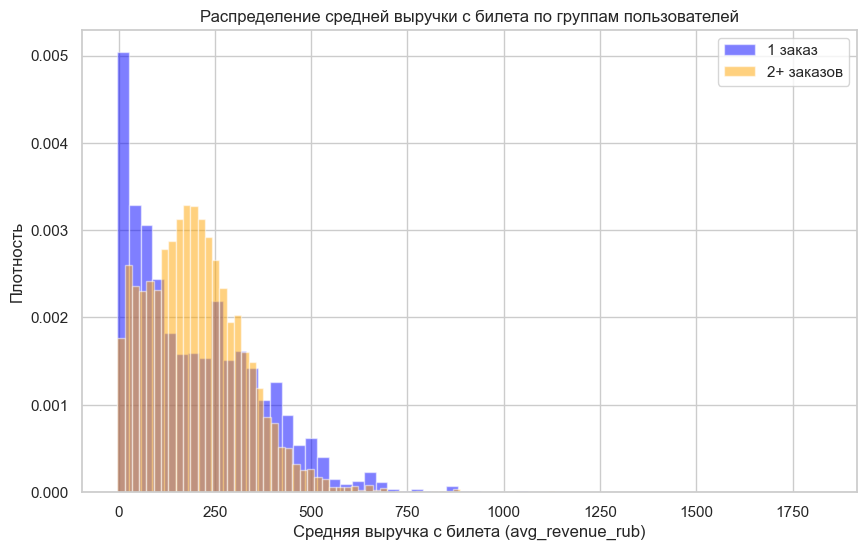

In [39]:
# группы пользователей
single_order_users = filtered_profile[filtered_profile['total_orders'] == 1]
returning_users = filtered_profile[filtered_profile['total_orders'] >= 2]

# Расчет средней выручки с билета для каждой группы
single_order_revenue = single_order_users['mean_revenue_rub'] / single_order_users['mean_tickets_count']
returning_revenue = returning_users['mean_revenue_rub'] / returning_users['mean_tickets_count']

# Создаем одинаковый интервал
bins = 60 

# Построение графиков
plt.figure(figsize=(10, 6))
plt.hist(single_order_revenue, bins=bins, alpha=0.5, density=True, label='1 заказ', color='blue')
plt.hist(returning_revenue, bins=bins, alpha=0.5, density=True, label='2+ заказов', color='orange')

plt.xlabel('Средняя выручка с билета (avg_revenue_rub)')
plt.ylabel('Плотность')
plt.title('Распределение средней выручки с билета по группам пользователей')
plt.legend()
plt.grid(True)
plt.show()

#### Промежуточный вывод 

* большинство пользователей совершивших 1 заказ, приобрели более дешевые билеты и принесли меньше выручки с одного купленого билета.
* большинство пользователей совершивших 2 и более зааказа приобрели более дорогие билеты и принесли больше выручки с одного купленого билета.

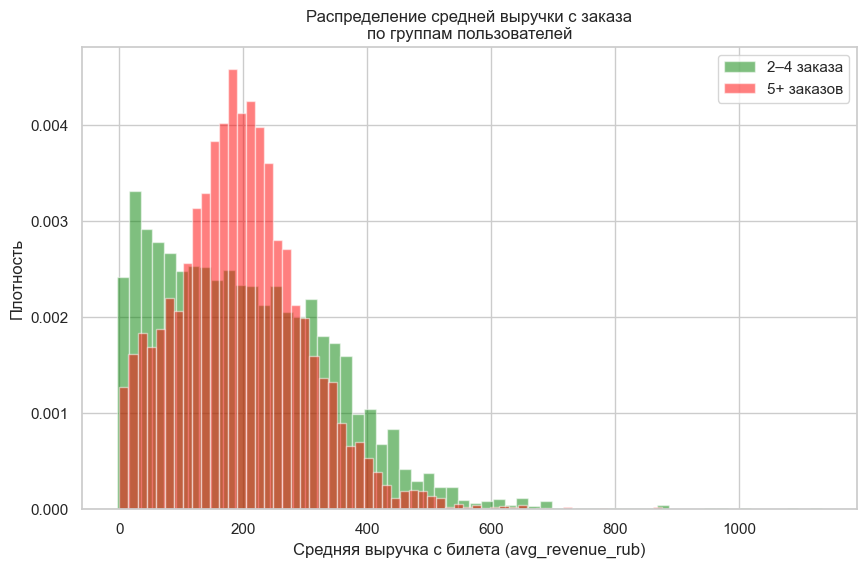

In [40]:
# Создайте группы пользователей
group_2_4 = filtered_profile[(filtered_profile['total_orders'] >= 2) & (filtered_profile['total_orders'] <= 4)]
group_5_plus = filtered_profile[filtered_profile['total_orders'] >= 5]

# Рассчитаем среднюю выручку с заказа у каждой группы
avg_revenue_2_4 = group_2_4['mean_revenue_rub'] / group_2_4['mean_tickets_count']
avg_revenue_5_plus = group_5_plus['mean_revenue_rub'] / group_5_plus['mean_tickets_count']

# Задайте одинаковые bins для сравнения
bins = 60  # или другое подходящее число

# Построение графиков
plt.figure(figsize=(10, 6))
plt.hist(avg_revenue_2_4, bins=bins, alpha=0.5, density=True, label='2–4 заказа', color='green')
plt.hist(avg_revenue_5_plus, bins=bins, alpha=0.5, density=True, label='5+ заказов', color='red')

plt.xlabel('Средняя выручка с билета (avg_revenue_rub)')
plt.ylabel('Плотность')
plt.title('Распределение средней выручки с заказа\nпо группам пользователей')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
mean_revenue_2_4 = avg_revenue_2_4.mean()
mean_revenue_5_plus = avg_revenue_5_plus.mean()

print(f"Средняя выручка с заказа для 2–4 заказов: {mean_revenue_2_4:.2f} руб.")
print(f"Средняя выручка с заказа для 5+ заказов: {mean_revenue_5_plus:.2f} руб.")

Средняя выручка с заказа для 2–4 заказов: 202.44 руб.
Средняя выручка с заказа для 5+ заказов: 196.19 руб.


#### Промежуточный вывод 

    Большая часть пользователей с 2-4 заказами приносит меньшую выручку чем пользователи которые сделали 5 и более заказов

In [42]:
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2', '2-3', '3-5', '5+']

filtered_profile['ticket_segment'] = pd.cut(
    filtered_profile['mean_tickets_count'],
    bins=bins,
    labels=labels,
    right=False
)

segment_stats = filtered_profile.groupby('ticket_segment').agg(
    total_users=('user_id', 'count'),
    repeat_purchases=('total_orders', lambda x: (x > 1).sum())
)

segment_stats['share_repeat'] = segment_stats['repeat_purchases'] / segment_stats['total_users']

print(segment_stats)


                total_users  repeat_purchases  share_repeat
ticket_segment                                             
1-2                    2405              1227      0.510187
2-3                    9451              6942      0.734525
3-5                    8993              4846      0.538864
5+                      647               114      0.176198


C:\Users\pook\AppData\Local\Temp\ipykernel_10268\2626038958.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = filtered_profile.groupby('ticket_segment').agg(


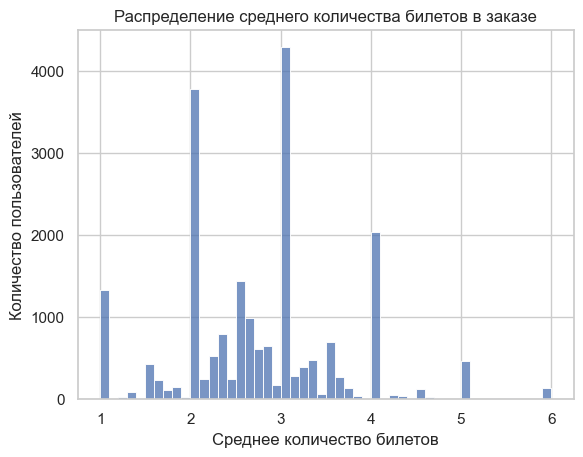

count    21496.000000
mean         2.739208
std          0.907298
min          1.000000
25%          2.000000
50%          2.750000
75%          3.090909
max          6.000000
Name: mean_tickets_count, dtype: float64
  segment  total_users  repeaters  share_repeated
0     1-2         2405       1227        0.510187
1     2-3         9451       6942        0.734525
2     3-5         8993       4846        0.538864
3      5+          647        114        0.176198


C:\Users\pook\AppData\Local\Temp\ipykernel_10268\1013647224.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = temp_df.groupby('segment').agg(


In [51]:
# график распределения среднего кол-ва билетов в заказе
sns.histplot(filtered_profile['mean_tickets_count'], bins=50)
plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Количество пользователей')
plt.show()

# Описание распределения
print(filtered_profile['mean_tickets_count'].describe())

# Сегментирование пользователей
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2', '2-3', '3-5', '5+']

temp_df = filtered_profile.copy()
temp_df['segment'] = pd.cut(temp_df['mean_tickets_count'], bins=bins, labels=labels, right=False)

# Подсчёт общего числа пользователей и доли с повторными покупками по сегментам
segment_stats = temp_df.groupby('segment').agg(
    total_users=('user_id', 'count'),
    repeaters=('returned', 'sum')
).reset_index()

segment_stats['share_repeated'] = segment_stats['repeaters'] / segment_stats['total_users']

print(segment_stats)

# Промежуточный вывод 

* Распределение пользователей по сегментам неравномерное, с высокой концентрацией в пределах 2-3 билетов.
* Высокая доля повторных заказов в сегментах с меньшим количеством билетов (особенно 2-3), что говорит о большей лояльности или привычке возвращаться.
* Сегмент с более чем 5 билета показывает низкую долю повторных заказов, возможно, это случайные или разовые клиенты.

  first_order_dayofweek  total_users  repeaters  percent_repeated
0                Friday         3240       1931         59.598765
1                Monday         2907       1824         62.745098
2              Saturday         3303       2068         62.609749
3                Sunday         2757       1648         59.775118
4              Thursday         3101       1839         59.303450
5               Tuesday         3157       1945         61.609123
6             Wednesday         3031       1874         61.827780


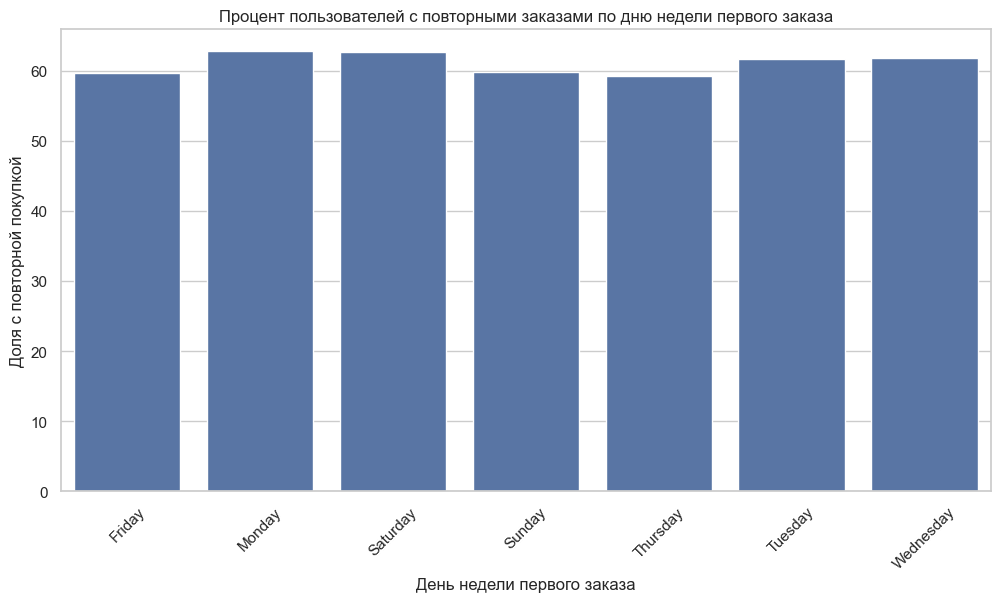

In [52]:
# Поиск дня недели из даты первого заказа
filtered_profile['first_order_dayofweek'] = filtered_profile['first_order_dt'].dt.day_name()

# Группировка по дню недели
grouped = filtered_profile.groupby('first_order_dayofweek').agg(
    total_users=('user_id', 'count'),
    repeaters=('returned', 'sum')  # предполагается, что 'returned' — булев тип
).reset_index()

# Рассчитываем долю повторных
grouped['percent_repeated'] = grouped['repeaters'] / grouped['total_users'] * 100
print(grouped)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='first_order_dayofweek', y='percent_repeated', data=grouped)
plt.title('Процент пользователей с повторными заказами по дню недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля с повторной покупкой')
plt.xticks(rotation=45)
plt.show()

#### Промежуточный вывод

* Самая высокая доля повторных заказов — у пользователей, начавших в Wednesday (61.83%) и Tuesday (61.61%).
* Самая низкая доля — у Friday (59.60%) и Sunday (59.78%).

Влияние дня недели первого заказа на вероятность возврата есть, но оно не очень выражено.

In [53]:
# Сегментирование пользователей
group_2_4 = filtered_profile[filtered_profile['total_orders'].between(2, 4)]
group_5plus = filtered_profile[filtered_profile['total_orders'] >= 5]

# Расчет средней продолжительности интервала между заказами для каждой группы
mean_lifetime_2_4 = group_2_4['mean_days_between_orders'].mean()
mean_lifetime_5plus = group_5plus['mean_days_between_orders'].mean()

print(f"Средний интервал (2-4 заказы): {mean_lifetime_2_4:.2f} дней")
print(f"Средний интервал (5+ заказов): {mean_lifetime_5plus:.2f} дней")

Средний интервал (2-4 заказы): 19.42 дней
Средний интервал (5+ заказов): 9.97 дней


Пользователи с коротким интервалом между заказами чаще возвращаются.

#### Корреляционный анализ количества покупок и признаков пользователя

C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 21496. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(


                          total_orders
total_orders                  1.000000
mean_revenue_rub              0.223988
mean_tickets_count            0.342254
mean_days_between_orders      0.348248


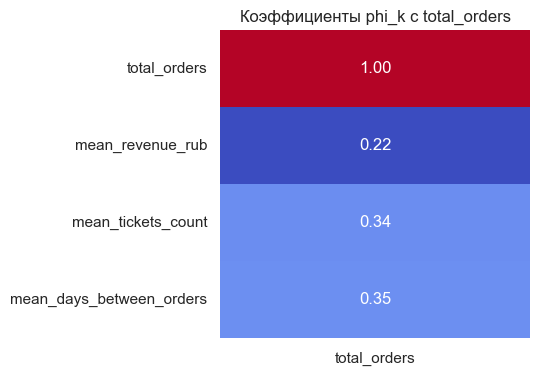

In [47]:
# Список признаков
interval_cols = ['total_orders', 'mean_revenue_rub', 'mean_tickets_count', 'mean_days_between_orders']

# Рассчитываем матрицу phi_k
phik_corr = filtered_profile.phik_matrix(interval_cols=interval_cols)

# Проеобразовать DataFrame из серии для отображения
subset_corr = phik_corr.loc[['total_orders'], interval_cols].T  # транспонируем для удобства
print(subset_corr)

plt.figure(figsize=(4, 4))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Коэффициенты phi_k с total_orders')
plt.show()


При общем расчете коэфициентов наблюдается очень слабая положительная связь между количеством заказов пользователя и всеми перечислеными признаками 

Для сегмента '1 заказ' недостаточно вариативности в total_orders.


C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 15378. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable segment for analysis 1. Dropping this column
  warnings.warn(


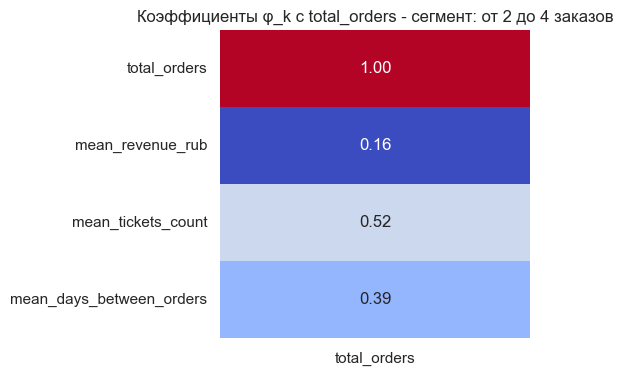

C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 6118. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable returned for analysis 1. Dropping this column
  warnings.warn(
C:\Users\pook\AppData\Roaming\Python\Python313\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique

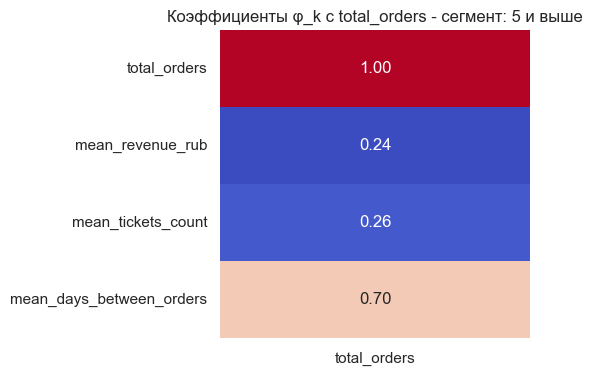

In [48]:
# Создайте сегменты
bins = [-1, 0.9, 4.1, float('inf')]
labels = ['1 заказ', 'от 2 до 4 заказов', '5 и выше']
filtered_profile['segment'] = pd.cut(
    filtered_profile['total_orders'], bins=bins, labels=labels
)

# Анализ по сегментам
for segment in labels:
    segment_data = filtered_profile[filtered_profile['segment'] == segment]
    
    # Проверка вариативности total_orders
    if segment_data['total_orders'].nunique() <= 1:
        print(f"Для сегмента '{segment}' недостаточно вариативности в total_orders.")
        continue
    
    # Исключаем нежелательные признаки для анализа
    analysis_vars = [col for col in interval_cols if col != 'user_id']
    
    # Расчет phi_k
    phik_corr = segment_data.phik_matrix(interval_cols=analysis_vars)
    subset_corr = phik_corr.loc[['total_orders'], analysis_vars].T
    
    # Визуализация
    plt.figure(figsize=(4, 4))
    sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
    plt.title(f'Коэффициенты φ_k с total_orders - сегмент: {segment}')
    plt.show()

#### Промежуточный вывод

* При общем расчете коэфициентов корреляции количества заказов пользователя наблюдается слабая положительная связь между и всеми перечислеными признаками.
    * Наибольшую связь показывают среднее количество дней между заказами пользователя 0.35 и среднее количество билетов в заказе 0.34.

* При расчете корреляции сегментов пользователей разделенных по количеству заказов:
    * для пользователей с 1 заказом кореляция не может быть расчитана из за малой вариативности данных.
    * для пользователей совершивших от 2 до 4 заказов наибольшую связь показывает среднее количество билетов в заказе 0.52
    * для пользователей совершивших 5 и более заказов наибольшую связь показывает среднее количество дней между заказами пользователя 0.7

### Общие выводы и рекомендации 

Общие выводы
1. Общая характеристика данных
* В датасете 15 столбцов, содержащих информацию о 290 611 покупках.
* В другом датасете — 357 строк с данными о курсе тенге к рублю за 2024 год.
* После объединения данные приведены к единой валюте — рублям.
* Была выполнена предобработка: нормализация текстовых данных, поиск дубликатов — дубликаты не найдены.
* В столбцах tickets_count, revenue_rub обнаружены выбросы, которые устранены фильтрацией по 99 перцентилю, что увеличивает качество анализа.
    2. Статистика по пользовательским сегментам
* Общее число уникальных пользователей — 21 847.
* Средняя выручка с одного заказа — примерно 544 рубля.
* Доля активных пользователей:
* 61.70% совершили 2 или более заказа.
* 29.01% — 5 и более заказов.
* Общие заказы — около 287 606.
* Среднее число билетов в заказе — 2.74.
* Средний интервал между покупками — около 16 дней.
    3. Поведенческие особенности
* Среди возвратившихся пользователей наибольшая доля — в сегменте 2–4 заказа.
* Влияние дня недели первого заказа на возврат есть, но слабое.
* Пользователи, совершающие заказы с коротким интервалом, чаще возвращаются.
* Корреляционный анализ показывает:
* В сегменте 2–4 заказов максимальная связь с mean_tickets_count (коэффициент 0.52).
* В сегменте 5+ заказов — сильная связь с interval_days (0.7).
#### Рекомендации
* Фокус на пользователей с коротким интервалом между покупками — они чаще возвращаются, значит, их можно стимулировать акциями или программами лояльности.